# 1. Procesamiento y etiquetado de fondos

Trabajaremos con las imagenes en monocolor y cada imagen es de 62 x 47 pixeles, por lo que vamos a procesar las fotografías de fondos para tener las mismas propiedades.

El total de imagenes de rostros es 13233, asi que trataremos de llegar a un número similar de imagenes de fondos. Para lograr eso dividiremos las fotografías.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Juntamos los imagenes de caras con las imagenes de fondos para obtener nuestro dataset, con un total de 26353 muestras. Etiquetamos las caras con 1 (clase positiva) y los fondos con 2 (clase negativa). Luego de esto, particionamos el dataset en train y test utilizando la proporción 80% - 20%.

In [1]:
import matplotlib.pyplot as plt

import code.carga as carga

positive_faces = carga.positive_patches()
negative_faces = carga.negative_patches(820 ,"./imagenes/")

4106256


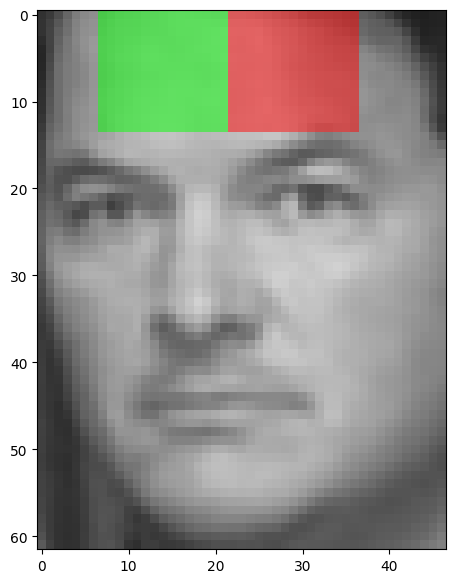

In [3]:
import code.features as feat
import numpy as np
from skimage.feature import draw_haar_like_feature

haar = feat.HAARPreprocess()


positive_example = positive_faces[10]
negative_example = negative_faces[10]
image = haar.preprocess_img(positive_example)
coord, _ = haar.roi_haar()

print(len(coord))
plt.figure(figsize = (7,7))

feature_image = draw_haar_like_feature(positive_example, 0, 0,
                                       positive_example[0],
                                       positive_example[1],
                                       [coord[10000]]
                                      )

plt.imshow(feature_image, cmap='gray')
plt.show()
# fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# ax[0].imshow(positive_example, cmap='gray')
# ax[0].set_title('Imagen de rostro')

# ax[1].imshow(negative_example, cmap='gray')
# ax[1].set_title('Imagen de fondo')

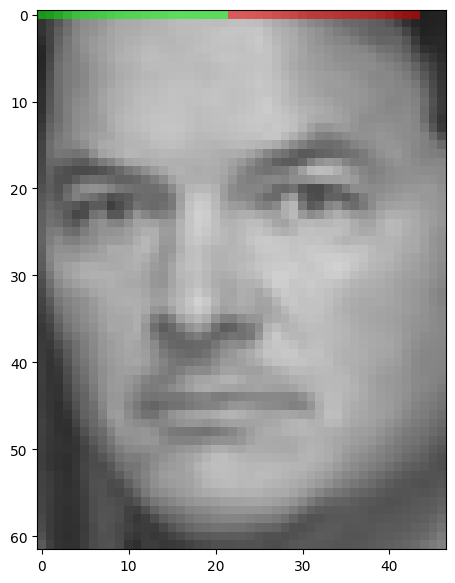

In [7]:
plt.figure(figsize = (7,7))
feature_image = draw_haar_like_feature(positive_example, 0, 0,
                                       positive_example[0],
                                       positive_example[1],
                                       [coord[21]]
                                      )

plt.imshow(feature_image, cmap='gray')
plt.show()
# fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# ax[0].imshow(positive_example, cmap='gray')
# ax[0].set_title('Imagen de rostro')

# ax[1].imshow(negative_example, cmap='gray')
# ax[1].set_title('Imagen de fondo')

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.20, random_state=42)

print(f'muestras entrenamiento: {X_train.shape}')
print(f'muestras validacion: {X_test.shape}')

NameError: name 'samples' is not defined

La siguiente celda es una prueba que se puede borrar es HAAR

In [ ]:
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

ii = integral_image(X_train[0])
H = X_train[0].shape[0]
print(H)
print(W)
W = X_train[0].shape[1]
haar = haar_like_feature(ii, 0, 0, H, W)

feature_coord, feature_type = haar_like_feature_coord(width=W,height=H)
print(feature_type)


62
47
['type-2-x' 'type-2-x' 'type-2-x' ... 'type-4' 'type-4' 'type-4']


In [ ]:
from sklearn.metrics import classification_report
import re

report_test = classification_report(y_train, y_pred,  output_dict=True)

print(report_test['0']['precision'])

0.986701876827313


## 3. Preprocesamiento de datos

Como primer acercamiento vamos entrenar tres modelos utilizando solamente una matriz que contiene los HOG features de cada imágen.

EN EL CODIGO SOLO ESTA EL DE HOG faltan los otros dos

In [ ]:
from skimage import data, color, feature

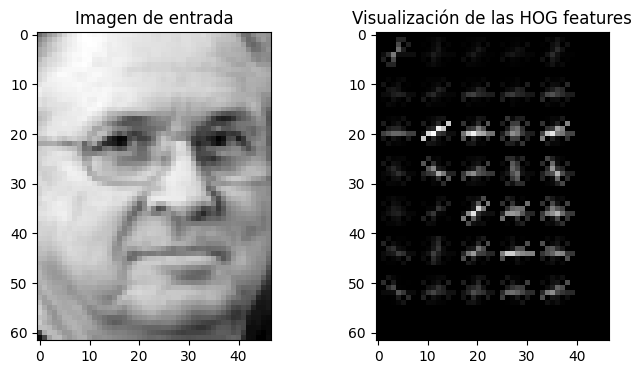

In [ ]:
muestra_ejemplo = X_train[100]

hog_features, hog_vis = feature.hog(muestra_ejemplo, visualize=True, feature_vector=False)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(muestra_ejemplo, cmap='gray')
ax[0].set_title('Imagen de entrada')

ax[1].imshow(hog_vis, cmap='gray')
ax[1].set_title('Visualización de las HOG features');

In [ ]:
n_train_rows = X_train.shape[0]
n_test_rows = X_test.shape[0]

X_train_hog = np.array([feature.hog(X_train[i]) for i in range(n_train_rows)])
X_test_hog = np.array([feature.hog(X_test[i]) for i in range(n_test_rows)])

In [ ]:
X_train_hog.shape

(21082, 1215)

### 3.1 Regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_cv = LogisticRegression(solver='liblinear', random_state=42)
#log_reg_cv = LogisticRegressionCV(cv=5, solver='liblinear', random_state=42)
log_reg_cv.fit(np.reshape(X_train,(21082, 2914)) , y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve

In [ ]:
y_pred_train_hog = log_reg_cv.predict(np.reshape(X_train,(21082, 2914)))

In [ ]:
confusion_matrix(y_train, y_pred_train_hog)

array([[10462,    72],
       [  141, 10407]])

In [ ]:
precision_score(y_train, y_pred_train_hog)

0.9931291153736044

In [ ]:
recall_score(y_train, y_pred_train_hog)

0.9866325369738339

In [ ]:
y_pred_test_hog = log_reg_cv.predict(np.reshape(X_test,(5271, 2914)))

In [ ]:
confusion_matrix(y_test, y_pred_test_hog)

array([[2505,   81],
       [  37, 2648]])

In [ ]:
precision_score(y_test, y_pred_test_hog)

0.9703187980945401

In [ ]:
recall_score(y_test, y_pred_test_hog)

0.986219739292365

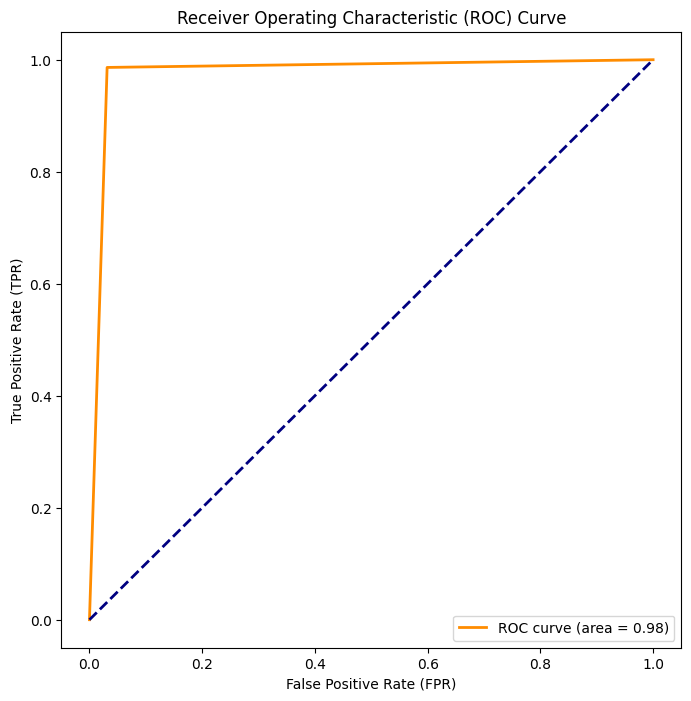

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Supongamos que tienes las probabilidades de predicción y_true y y_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_hog)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### 3.2 Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
random_forest = RandomForestClassifier()

In [ ]:
random_forest.fit(X_train_hog, y_train)

RandomForestClassifier()

In [ ]:
y_pred_forest_hog = random_forest.predict(X_test_hog)

In [ ]:
confusion_matrix(y_test, y_pred_forest_hog)

array([[2580,    6],
       [  47, 2638]])

## 3.3 K vecinos más cercanos

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#probar con diferentes k
knn = KNeighborsClassifier()

In [ ]:
knn.fit(np.reshape(X_train,(21082, 2914)), y_train)

KNeighborsClassifier()

In [ ]:
y_pred_knn = knn.predict(np.reshape(X_test,(5271, 2914)))

In [ ]:
confusion_matrix(y_test, y_pred_knn)

array([[2559,   27],
       [ 318, 2367]])

In [ ]:
precision_score(y_test, y_pred_knn)

0.9887218045112782

In [ ]:
recall_score(y_test, y_pred_knn)

0.8815642458100559

### 3.2 Boosting

RESULTADOS

FALTAN AGREGAR LAS CURVAS DE ALGUNOS MODELOS SOLO A MODO DE EJEMPLO

In [ ]:
%run /content/entrega_final/code/test.py

asdas


Preprocessing Images HAARPreprocess:   3%|▎         | 693/21082 [32:16<15:11:29,  2.68s/image]

In [3]:
import ipywidgets as widgets
from IPython.display import display

uploader = widgets.FileUpload(
    accept='.jpg',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

imagen_np = None

def on_file_changed(change):
    global imagen_np
    with output:
        imagen_cargada = change['new']
        # Convertir la lista de bytes en un objeto de imagen usando Pillow
        imagen_pil = Image.open(io.BytesIO(imagen_cargada[0]))

        # Convertir la imagen de Pillow a un array de NumPy
        imagen_np = np.array(imagen_pil)
        print("sdf")

output = widgets.Output()

display(uploader, output)

uploader.observe(on_file_changed, names='data')


FileUpload(value={}, accept='.jpg', description='Upload')

Output()

In [4]:

from PIL import Image
import numpy as np
import io

# Mostrar la forma del array NumPy resultante
print("Forma del array NumPy:", imagen_np.shape)


Forma del array NumPy: (804, 1114, 3)


In [10]:
from PIL import Image
import io
import numpy as np
from skimage import data, color, feature
from skimage.transform import resize, rescale


# Verificar la forma del arreglo NumPy


size = (62, 47)

test_image = imagen_np
print(imagen_np.shape)
test_image = color.rgb2gray(test_image)
#test_image = rescale(test_image, (test_image.shape[0])/18900 )
test_image = test_image[:160, 40:180]
print(test_image.shape)

# Ni, Nj = (int(true_scale*s) for s in size)
# indices = np.array(indices)

(804, 1114, 3)
(160, 140)


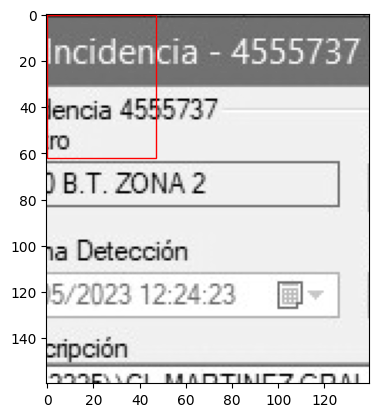

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')

true_scale = 1
Ni, Nj = (int(true_scale * s) for s in size)

ax.add_patch(plt.Rectangle((0, 0), Nj, Ni, edgecolor='red', alpha=1, lw=1, facecolor='none'))
plt.show()

In [11]:
# positive_faces = carga.positive_patches()
    # negative_faces = carga.negative_patches(13136 , './imagenes/')
    # print(negative_faces.shape)

    # # Etiquetas para caras (clase positiva)
    # positive_labels = np.tile(1, 13233)

    # # Etiquetas para fondos (clase negativa)
    # negative_labels = np.tile(0, 13110)

    # samples = np.concatenate((positive_faces, negative_faces))
    # labels = np.concatenate((positive_labels, negative_labels))
    # X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.20, random_state=42)

    # # X_train = X_train[10:100]
    # # y_train = y_train[10:100]

    # # X_test = X_test[10:30]
    # # y_test = y_test[10:30]

    # features_methods = [feat.Reshape() ,feat.HOGPrepocess(), feat.HAARPreprocess()]
    # #podemos pasar parametros si es necesario

    # knn_classifier = clf.KNNClassifier()
    # dtree_classifier = clf.DTreeClassifier()
    # logistic_regression_classifier = clf.LogisticRegressionClassifier()
    # rf_classifier = clf.RFClassifier()

    # classifiers = [knn_classifier]#, logistic_regression_classifier,dtree_classifier, rf_classifier]

    # results = []
    # for fea in features_methods:
    #     X_train_prep = fea.preprocess_imgs(X_train)
    #     X_test_prep = fea.preprocess_imgs(X_test)
    #     for cls in classifiers:
    #         y_test, y_pred, report_test, ti = test_classifier(cls, fea, X_train_prep, X_test_prep, y_train, y_test)
    #         conf_matrix = confusion_matrix(y_test, y_pred)
    #         fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    #         roc_auc = auc(fpr, tpr)
    #         tp, fp, fn, tn = conf_matrix.ravel()
    #         #print(f"Testing {cls.__class__.__name__} con {prep.__class__.__name__} {report_test['accuracy']} {report_test['macro avg']['precision']} {report_test['macro avg']['recall']} {report_test['macro avg']['f1-score']} {ti}")
    #         results.append([
    #             cls.__class__.__name__,
    #             fea.__class__.__name__,
    #             report_test['accuracy'],
    #             report_test['1']['precision'],
    #             tp / (tp + fn),
    #             fp / (tn + fp),
    #             roc_auc,
    #             balanced_accuracy_score(y_test,y_pred),
    #             report_test['1']['f1-score'],
    #             ti
    #         ])  
    #         #print(f"Precision: {report_test}")
    # headers = ["Classifier", "Preprocessing", "Accuracy", "Precision", "Recall/TPR", "FPR", "F1-Score", "ROC curve (area)", "Balanced Accuracy", "Time Train"]
    # print(tabulate(results, headers, tablefmt="grid"))
